In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import shap
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt
from scipy.stats import gaussian_kde

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Rebuilding font cache. This usually happens after installing or updating proplot.


## loading and exploring the data

In [2]:
acid_rain_data = pd.read_csv('/Users/zeqinhuang/Documents/paper/acid_rain/machine_learning_data/ml_data_all_stations.csv',header=0,index_col=0)
acid_rain_data = acid_rain_data.replace({'Urban':1,'Rural':0})
acid_rain_data.shape

(28655, 37)

In [3]:
acid_rain_data.describe()

,Rain_amount,pH,conductivity,SO42-,NO3-,F-,Cl-,NH4+,Ca2+,Mg2+,...,SO2_month_mean,NO2_daily_max,NO2_month_mean,O3_daily_max,O3_month_mean,PM10_daily_max,PM10_month_mean,station_type,LON,LAT
count,28654.000000,28654.000000,28650.000000,25819.000000,25668.000000,19987.000000,22395.000000,19923.000000,19915.000000,19375.000000,...,28655.000000,28655.000000,28655.000000,28655.000000,28655.000000,28655.000000,28655.000000,28655.000000,28655.000000,28655.000000
mean,23.773248,5.604435,3.388545,4.200728,2.790670,0.188249,1.494503,1.149296,1.548216,0.177356,...,0.020488,0.066432,0.035399,0.147842,0.049099,0.107095,0.050928,0.882150,113.533942,22.819021
std,27.190530,0.785001,4.416304,6.142494,3.484104,0.399686,3.098390,1.286578,2.592075,0.386608,...,0.019739,0.030941,0.015609,0.064327,0.016487,0.058428,0.023767,0.322436,0.545594,0.259390
min,0.100000,2.610000,0.040000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,0.003068,0.011657,0.005497,0.017089,0.004067,0.018373,0.011311,0.000000,112.471670,22.488611
25%,6.800000,5.030000,1.320000,1.340000,1.000000,0.040000,0.490000,0.420000,0.390000,0.040000,...,0.008028,0.044096,0.023868,0.095150,0.037381,0.068648,0.034713,1.000000,113.077780,22.550000
50%,14.700000,5.700000,2.300000,2.650000,1.900000,0.100000,0.900000,0.820000,0.840000,0.090000,...,0.012639,0.061037,0.033192,0.132090,0.048387,0.095250,0.045065,1.000000,113.368890,22.851667
75%,30.600000,6.160000,4.020000,5.280000,3.370000,0.220000,1.600000,1.420000,1.730000,0.180000,...,0.025156,0.082217,0.044742,0.200534,0.059835,0.128008,0.062040,1.000000,114.063610,23.053611
max,458.200000,8.860000,127.500000,276.495000,88.300000,28.200000,168.000000,32.630000,63.580000,14.500000,...,0.167369,0.234146,0.107061,0.343564,0.149376,0.570886,0.193337,1.000000,114.648060,23.229722


In [4]:
acid_rain_data.describe(exclude=np.number)

,station
count,28655
unique,28
top,Yuexiu
freq,1273


## splite the data into training and testing sets and build an xgboost DMatrix

In [5]:
acid_rain_data = acid_rain_data.drop(acid_rain_data[acid_rain_data['pH'].isna()].index)
X = acid_rain_data.drop(['pH','conductivity', 'SO42-', 'NO3-', 'F-', 'Cl-', 'NH4+', 'Ca2+', \
                         'Mg2+', 'Na+', 'K+','station', 'station_type', \
                         'O3_daily_max','O3_month_mean',\
                         'total_precipitation'],axis=1)
y = acid_rain_data[['pH']]

In [6]:
# Split the data, 0.3 test size
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.3)
dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test, y_test)

## training

In [7]:
# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "auto"}

n = 1000
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
)

## evaluation

In [8]:
preds = model.predict(dtest_reg)
rmse = mean_squared_error(y_test, preds, squared=False)
print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 0.573


## using validation sets during training

In [9]:
params = {"objective": "reg:squarederror", "tree_method": "auto"}
n = 1000
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=100 # Every ten rounds
)

[0]	train-rmse:3.64690	validation-rmse:3.65472
[100]	train-rmse:0.40471	validation-rmse:0.58318
[200]	train-rmse:0.30392	validation-rmse:0.57740
[300]	train-rmse:0.23395	validation-rmse:0.57325
[400]	train-rmse:0.18638	validation-rmse:0.57278
[500]	train-rmse:0.14901	validation-rmse:0.57281
[600]	train-rmse:0.12296	validation-rmse:0.57301
[700]	train-rmse:0.10017	validation-rmse:0.57246
[800]	train-rmse:0.08387	validation-rmse:0.57262
[900]	train-rmse:0.06889	validation-rmse:0.57287
[999]	train-rmse:0.05794	validation-rmse:0.57319


In [10]:
ph_train_predict = model.predict(dtrain_reg)
ph_train_true = y_train['pH']
ph_train = pd.DataFrame({'predict':ph_train_predict, 'true':ph_train_true})

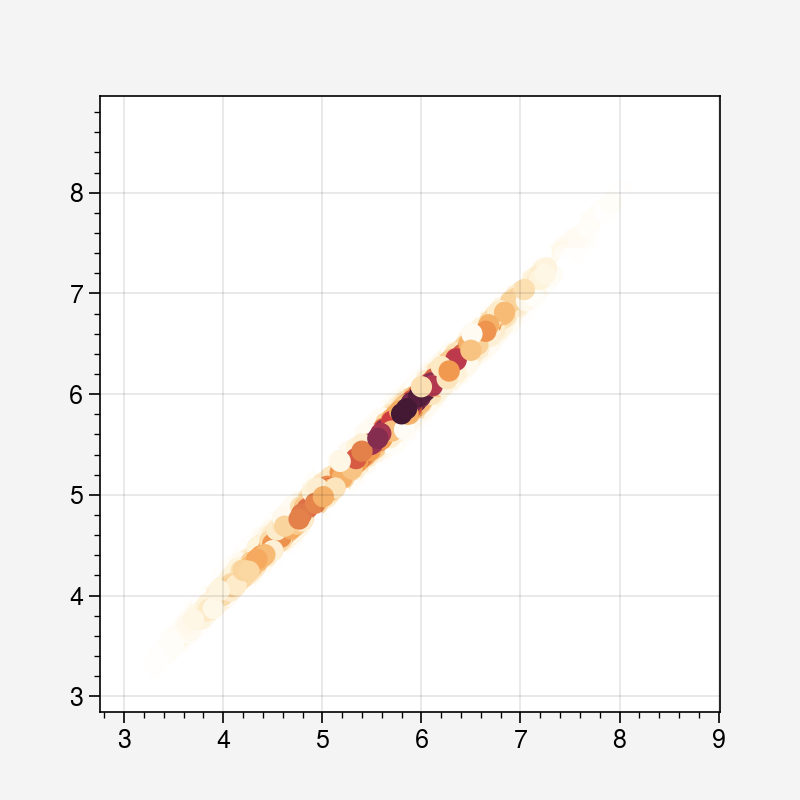

In [11]:
x = ph_train['true']
y = ph_train['predict']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)
plt.show()

In [12]:
ph_test_predict = model.predict(dtest_reg)
ph_test_true = y_test['pH']
ph_test = pd.DataFrame({'predict':ph_test_predict, 'true':ph_test_true})

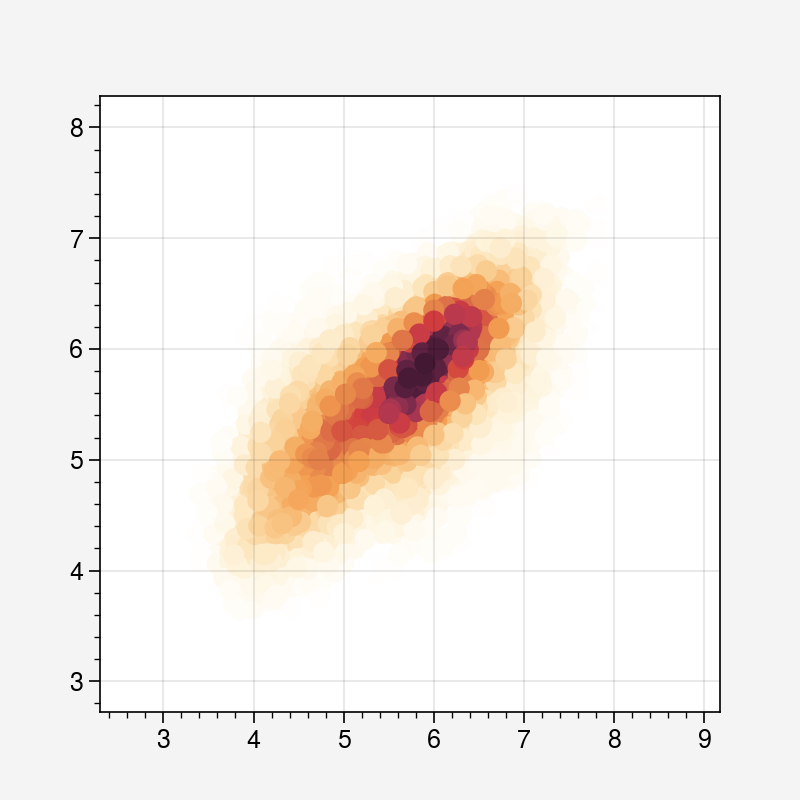

In [13]:
x = ph_test['true']
y = ph_test['predict']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)
plt.show()

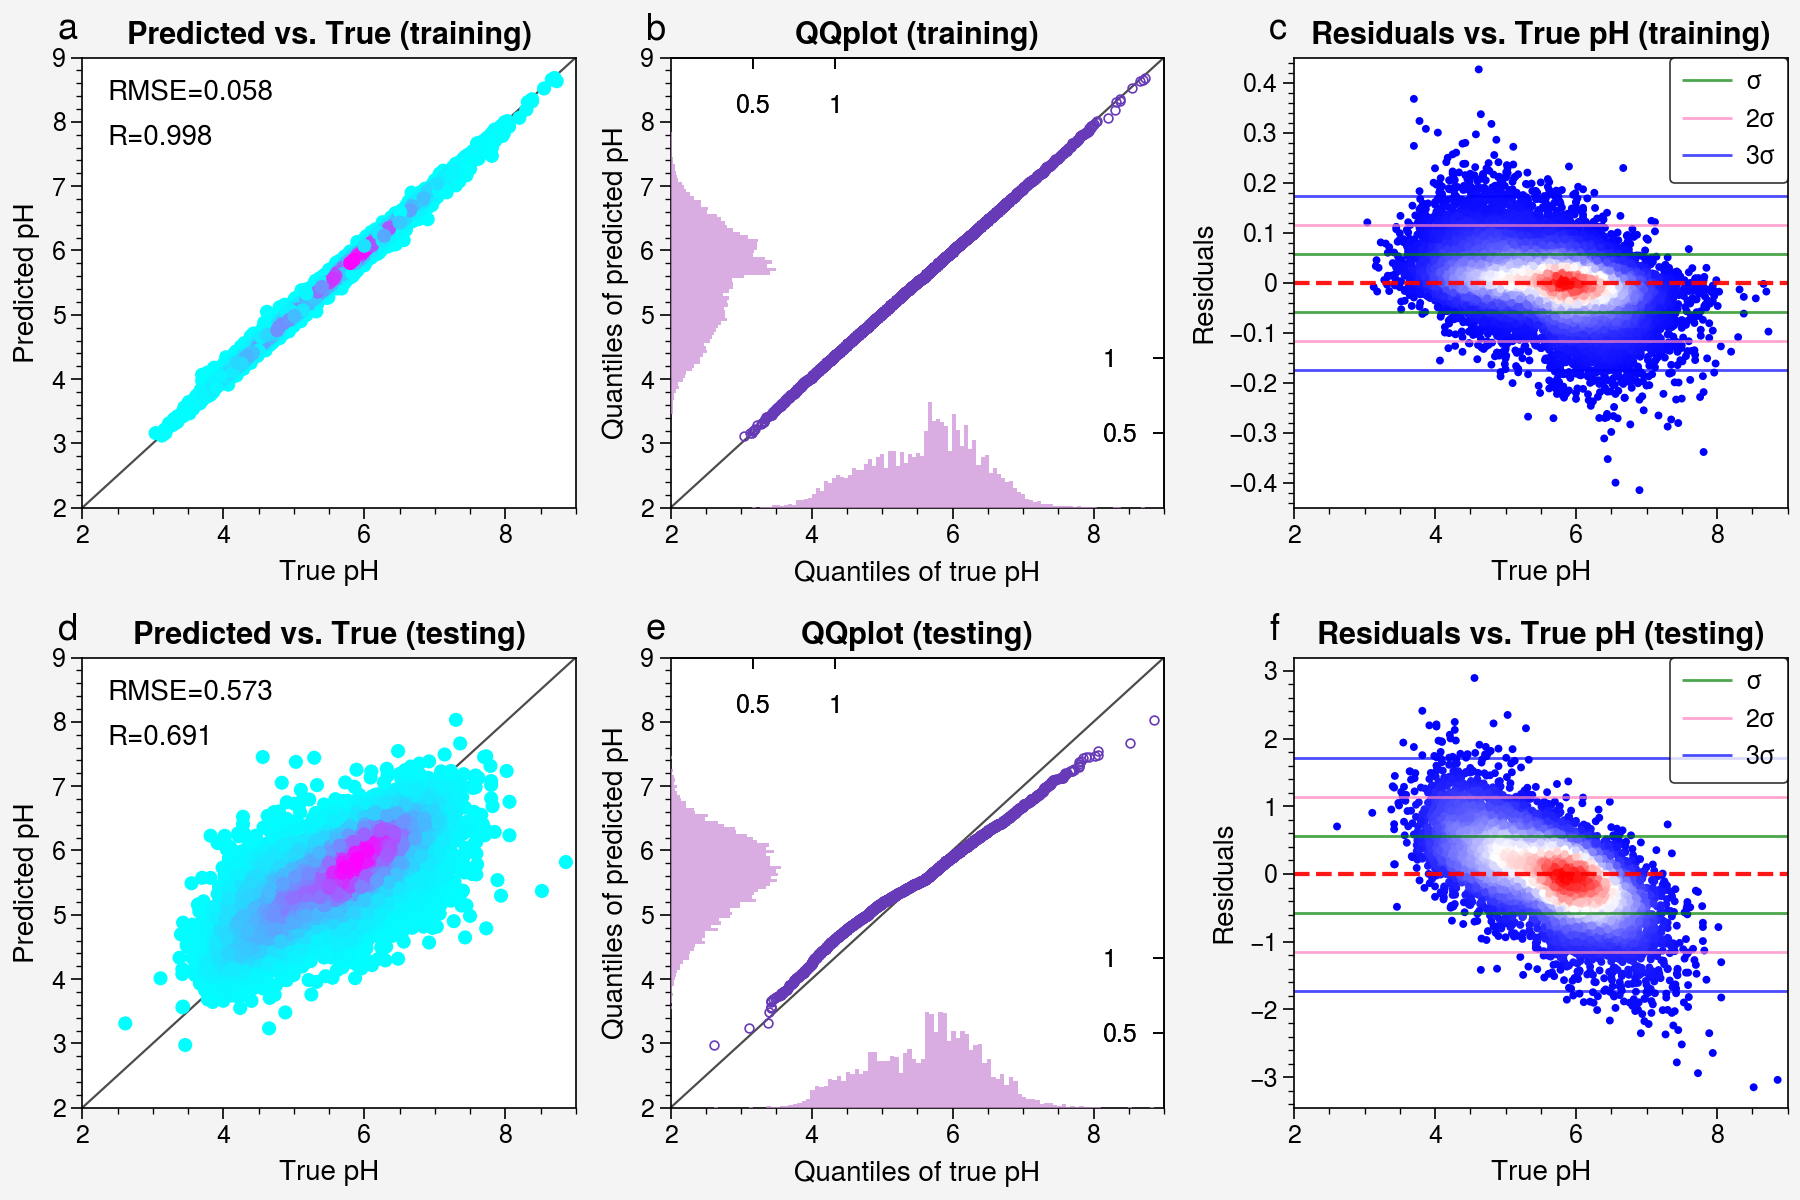

In [105]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
def add_panel_label(ax, label, x = 0.05, y = 1, fontsize=10):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=fontsize,  va='top', ha='left') #fontweight='bold',

import statsmodels.api as sm
fig, axs = pplt.subplots(ncols=3, nrows=2, figsize=(9,6),share=0)

# ax1 of scatter plot for train set
x = ph_train['true']
y = ph_train['predict']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
rmse_train = rmse(x,y)
corr_train = np.corrcoef(x,y)[0,1]

axs[0].axline((0, 0), slope=1,linewidth=0.8,color='black',alpha=0.7,zorder=0)
axs[0].scatter(x, y, c=z, s=20, cmap='cool')
axs[0].grid(False)
axs[0].set_ylabel('Predicted pH',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[0].set_xlabel('True pH',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[0].set_xlim([2,9])
axs[0].set_ylim([2,9])
axs[0].set_title('Predicted vs. True (training)',fontdict={'fontsize':11,'fontweight': 'bold'})
add_panel_label(axs[0],'RMSE='+str(round(rmse_train,3)), x=0.05, y=0.95)
add_panel_label(axs[0],'R='+str(round(corr_train,3)), x=0.05, y=0.85)
add_panel_label(axs[0],'a', x=-0.05, y=1.1, fontsize=13)

# ax2 qqplot for train set
x_q = np.sort(x)
y_q = np.sort(y)
axs[1].axline((0, 0), slope=1,linewidth=0.8,color='black',alpha=0.7,zorder=0)
axs[1].scatter(x_q, y_q, s=10, facecolor='none', edgecolor='#673AB7')
axs[1].grid(False)
axs[1].set_ylabel('Quantiles of predicted pH',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[1].set_xlabel('Quantiles of true pH',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[1].set_xlim([2,9])
axs[1].set_ylim([2,9])
axs[1].set_title('QQplot (training)',fontdict={'fontsize':11,'fontweight': 'bold'})
axs1_twinx = axs[1].twinx()
axs1_twinx.hist(x_q, 100, density=True, alpha=0.5, color = '#CE93D8')
axs1_twinx.set_ylim([0,3])
axs1_twinx.tick_params(axis="y",direction="in", pad=-22)
axs1_twinx.yaxis.set_tick_params(which='minor',right=False)
axs1_twinx.set_yticks(axs1_twinx.get_yticks()[1:3])
axs1_twinx.set_yticklabels([0.5,1])
axs1_twiny = axs[1].twiny()
axs1_twiny.hist(y_q, 100, density=True, orientation="horizontal", alpha=0.5, color = '#CE93D8')
axs1_twiny.set_xlim([0,3])
axs1_twiny.tick_params(axis="x",direction="in", pad=-22)
axs1_twiny.xaxis.set_tick_params(which='minor',top=False)
axs1_twiny.set_xticks([0.5,1])
axs1_twiny.set_xticklabels([0.5,1])
add_panel_label(axs[1],'b', x=-0.05, y=1.1, fontsize=13)

# ax3 residual plot for train set
res_train = y - x
res_train_std = np.std(res_train)
res_train_mean = np.mean(res_train)
xy_res_train = np.vstack([x,res_train])
z_res_train = gaussian_kde(xy_res_train)(xy_res_train)
axs[2].axhline(y=0, color='red', alpha=0.7, linewidth=1.5, linestyle='--')
p1 = axs[2].axhline(y=res_train_mean+res_train_std, color='green', alpha=0.7, linewidth=1, linestyle='-')
axs[2].axhline(y=res_train_mean-res_train_std, color='green', alpha=0.7, linewidth=1, linestyle='-')
p2 = axs[2].axhline(y=res_train_mean+res_train_std*2, color='pink', alpha=0.7, linewidth=1, linestyle='-')
axs[2].axhline(y=res_train_mean-res_train_std*2, color='pink', alpha=0.7, linewidth=1, linestyle='-')
p3 = axs[2].axhline(y=res_train_mean+res_train_std*3, color='blue', alpha=0.7, linewidth=1, linestyle='-')
axs[2].axhline(y=res_train_mean-res_train_std*3, color='blue', alpha=0.7, linewidth=1, linestyle='-')
axs[2].axhline(y=0, color='red', alpha=0.7, linewidth=1.5, linestyle='--')
axs[2].scatter(x, res_train, c=z_res_train, s=5, cmap='bwr')
axs[2].grid(False)
axs[2].set_ylabel('Residuals',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[2].set_xlabel('True pH',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[2].set_xlim([2,9])
axs[2].set_ylim([-0.45,0.45])
axs[2].set_title('Residuals vs. True pH (training)',fontdict={'fontsize':11,'fontweight': 'bold'})
axs[2].legend(
    [p1,p2,p3], ['σ','2σ','3σ'],fancybox = True,frameon=True, loc = 'upper right', #labelspacing = 1, #title='Legend', #bbox_to_anchor=[0.1,0.6],
    ncol=1,fontsize=11)
add_panel_label(axs[2],'c', x=-0.05, y=1.1, fontsize=13)

# ax4 of scatter plot for test set
x = ph_test['true']
y = ph_test['predict']
# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
rmse_test= rmse(x,y)
corr_test = np.corrcoef(x,y)[0,1]

axs[3].axline((0, 0), slope=1,linewidth=0.8,color='black',alpha=0.7,zorder=0)
axs[3].scatter(x, y, c=z, s=20, cmap='cool')
axs[3].grid(False)
axs[3].set_ylabel('Predicted pH',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[3].set_xlabel('True pH',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[3].set_xlim([2,9])
axs[3].set_ylim([2,9])
axs[3].set_title('Predicted vs. True (testing)',fontdict={'fontsize':11,'fontweight': 'bold'})
add_panel_label(axs[3],'RMSE='+str(round(rmse_test,3)), x=0.05, y=0.95)
add_panel_label(axs[3],'R='+str(round(corr_test,3)), x=0.05, y=0.85)
add_panel_label(axs[3],'d', x=-0.05, y=1.1, fontsize=13)

# ax5 qqplot for test set
x_q = np.sort(x)
y_q = np.sort(y)
axs[4].axline((0, 0), slope=1,linewidth=0.8,color='black',alpha=0.7,zorder=0)
axs[4].scatter(x_q, y_q, s=10, facecolor='none', edgecolor='#673AB7')
axs[4].grid(False)
axs[4].set_ylabel('Quantiles of predicted pH',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[4].set_xlabel('Quantiles of true pH',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[4].set_xlim([2,9])
axs[4].set_ylim([2,9])
axs[4].set_title('QQplot (testing)',fontdict={'fontsize':11,'fontweight': 'bold'})
axs4_twinx = axs[4].twinx()
axs4_twinx.hist(x_q, 100, density=True, alpha=0.5, color = '#CE93D8')
axs4_twinx.set_ylim([0,3])
axs4_twinx.tick_params(axis="y",direction="in", pad=-22)
axs4_twinx.yaxis.set_tick_params(which='minor',right=False)
axs4_twinx.set_yticks(axs4_twinx.get_yticks()[1:3])
axs4_twinx.set_yticklabels([0.5,1])
axs4_twiny = axs[4].twiny()
axs4_twiny.hist(y_q, 100, density=True, orientation="horizontal", alpha=0.5, color = '#CE93D8')
axs4_twiny.set_xlim([0,3])
axs4_twiny.tick_params(axis="x",direction="in", pad=-22)
axs4_twiny.xaxis.set_tick_params(which='minor',top=False)
axs4_twiny.set_xticks([0.5,1])
axs4_twiny.set_xticklabels([0.5,1])
add_panel_label(axs[4],'e', x=-0.05, y=1.1, fontsize=13)

# ax6 residual plot for test set
res_test = y - x
res_test_std = np.std(res_test)
res_test_mean = np.mean(res_test)
xy_res_test = np.vstack([x,res_test])
z_res_test = gaussian_kde(xy_res_test)(xy_res_test)
axs[5].axhline(y=0, color='red', alpha=0.7, linewidth=1.5, linestyle='--')
p1 = axs[5].axhline(y=res_test_mean+res_test_std, color='green', alpha=0.7, linewidth=1, linestyle='-')
axs[5].axhline(y=res_test_mean-res_test_std, color='green', alpha=0.7, linewidth=1, linestyle='-')
p2 = axs[5].axhline(y=res_test_mean+res_test_std*2, color='pink', alpha=0.7, linewidth=1, linestyle='-')
axs[5].axhline(y=res_test_mean-res_test_std*2, color='pink', alpha=0.7, linewidth=1, linestyle='-')
p3 = axs[5].axhline(y=res_test_mean+res_test_std*3, color='blue', alpha=0.7, linewidth=1, linestyle='-')
axs[5].axhline(y=res_test_mean-res_test_std*3, color='blue', alpha=0.7, linewidth=1, linestyle='-')
axs[5].axhline(y=0, color='red', alpha=0.7, linewidth=1.5, linestyle='--')
axs[5].scatter(x, res_test, c=z_res_test, s=5, cmap='bwr')
axs[5].grid(False)
axs[5].set_ylabel('Residuals',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[5].set_xlabel('True pH',fontdict={'fontsize':10,'fontweight': 'medium'})
axs[5].set_xlim([2,9])
axs[5].set_title('Residuals vs. True pH (testing)',fontdict={'fontsize':11,'fontweight': 'bold'})
axs[5].legend(
    [p1,p2,p3], ['σ','2σ','3σ'],fancybox = True,frameon=True, loc = 'upper right', #labelspacing = 1, #title='Legend', #bbox_to_anchor=[0.1,0.6],
    ncol=1,fontsize=11)
add_panel_label(axs[5],'f', x=-0.05, y=1.1, fontsize=13)

fig_dir = '/Users/zeqinhuang/Documents/paper/acid_rain/Figures/'
fig.savefig(fig_dir+'Fig7_model_evluation.pdf')
fig.savefig(fig_dir+'Fig7_model_evluation.png')

## corss validation

In [13]:
params = {"objective": "reg:squarederror", "tree_method": "auto"}
n = 1000

results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=20
)
results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,3.647244,0.001739,3.647766,0.011011
1,2.597332,0.000914,2.599085,0.011348
2,1.875976,0.000775,1.879932,0.010619
3,1.388019,0.001399,1.395486,0.010399
4,1.066793,0.001428,1.078122,0.007768
...,...,...,...,...
208,0.268418,0.004417,0.577197,0.006446
209,0.267931,0.004629,0.577169,0.006329
210,0.267149,0.004466,0.577211,0.006444
211,0.266129,0.004312,0.577155,0.006544


In [14]:
best_rmse = results['test-rmse-mean'].min()
best_rmse

0.5770774146267109

# shapley importance

In [107]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

In [18]:
# shap.force_plot(shap_values[200])
shap.force_plot(shap_values[200],matplotlib=True,show=False)
# plt.tight_layout()
# plt.savefig('/Users/zeqinhuang/Desktop/scratch.pdf')
# plt.close()
plt.tight_layout()
plt.savefig('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/force_plot_SHAP_one_instance.pdf')
plt.savefig('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/force_plot_SHAP_one_instance.png')
plt.close()

In [19]:
# shap.plots.waterfall(shap_values[200])
shap.plots.waterfall(shap_values[200],show=False)
plt.tight_layout()
plt.savefig('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/waterfall_plot_one_instance.pdf')
plt.savefig('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/waterfall_plot_one_instance.png')
plt.close()

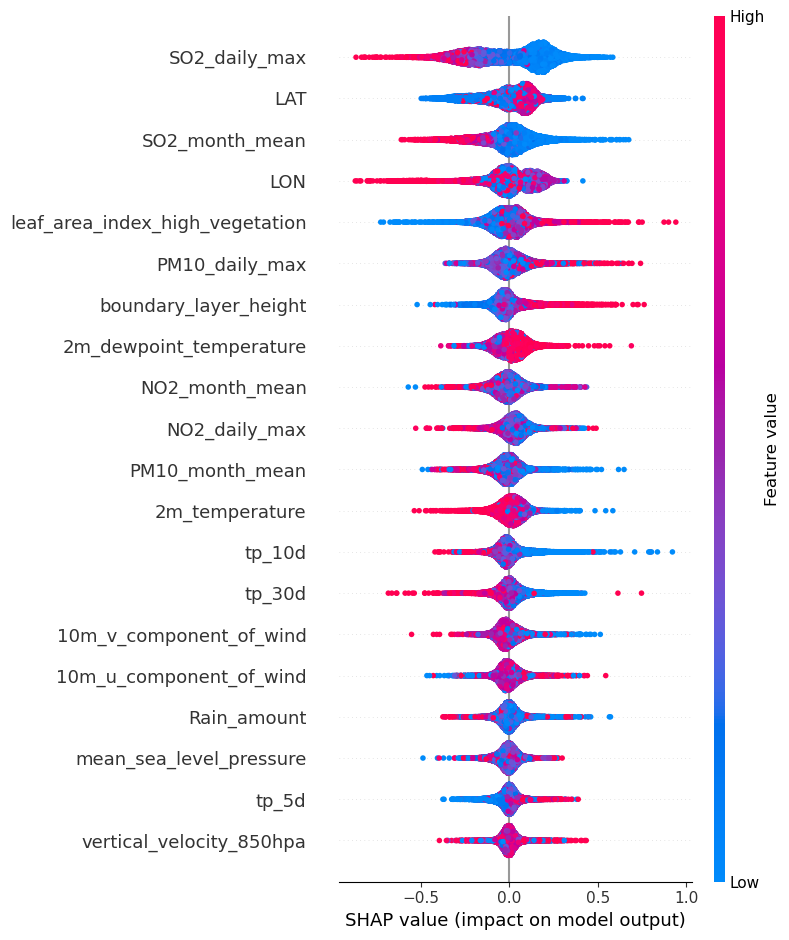

In [18]:
shap.summary_plot(shap_values)

In [19]:
shap.summary_plot(shap_values, X, max_display=30,show=False)
plt.tight_layout()
plt.savefig('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/global_SHAP.pdf')
plt.savefig('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/global_SHAP.png')
plt.close()

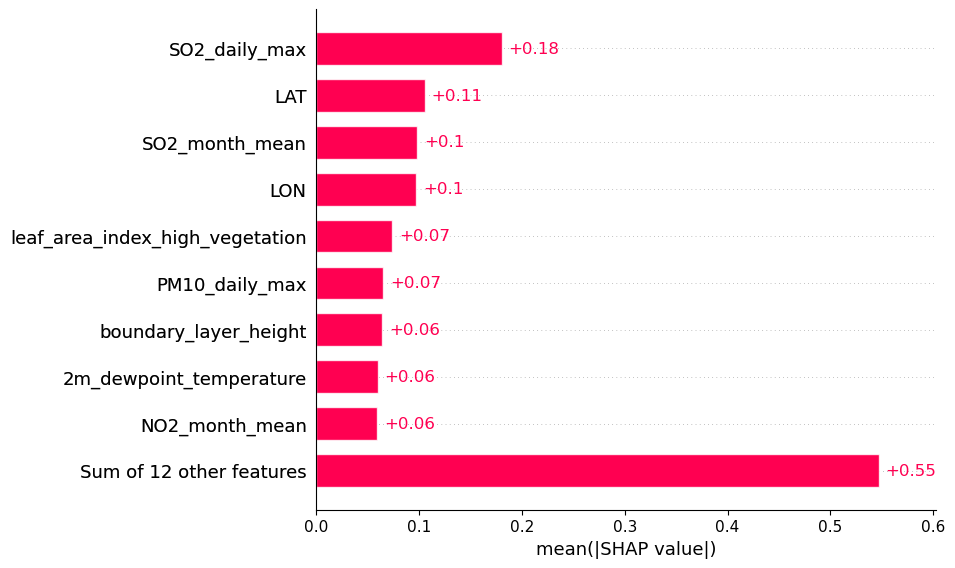

In [20]:
shap.plots.bar(shap_values,show=False)

In [21]:
shap.plots.bar(shap_values,show=False)
plt.tight_layout()
plt.savefig('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/feature_importance.pdf')
plt.savefig('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/feature_importance.png')
plt.close()

In [108]:
shap.plots.bar(shap_values,max_display=30,show=False)
plt.tight_layout()
plt.savefig('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/feature_importance_all.pdf')
plt.savefig('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/feature_importance_all.png')
plt.close()

invalid value encountered in log10
invalid value encountered in log10


In [22]:
# visualize the training set predictions
shap.initjs()
shap.force_plot(shap_values[:1000])
shap.save_html('/Users/zeqinhuang/Desktop/explainer.html', shap.force_plot(shap_values[:1000]))

In [41]:
for s in set(acid_rain_data['station']):
    fig = plt.figure(figsize=(7,5)) # ax1 = fig.add_subplot(111)
    X_s = X[acid_rain_data.station==s]
    shap_values_s = explainer(X_s)
    shap.plots.heatmap(shap_values_s, max_display=12,show=False,instance_order=range(len(shap_values_s)))
    plt.savefig('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/force_plot_org_order_' + s + '.pdf',bbox_inches='tight',pad_inches = 0)
    plt.savefig('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/force_plot_org_order_' + s + '.png',bbox_inches='tight',pad_inches = 0)
    plt.close()

In [42]:
for s in set(acid_rain_data['station']):
    fig = plt.figure(figsize=(7,5)) # ax1 = fig.add_subplot(111)
    X_s = X[acid_rain_data.station==s]
    shap_values_s = explainer(X_s)
    shap.plots.heatmap(shap_values_s, max_display=12,show=False)
    plt.savefig('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/force_plot_hclust_order_' + s + '.pdf',bbox_inches='tight',pad_inches = 0)
    plt.savefig('/Users/zeqinhuang/Documents/paper/acid_rain/Figures/force_plot_hclust_order_' + s + '.png',bbox_inches='tight',pad_inches = 0)
    plt.close()

# with station names as categories

In [25]:
acid_rain_data = pd.read_csv('/Users/zeqinhuang/Documents/paper/acid_rain/machine_learning_data/ml_data_all_stations.csv',header=0,index_col=0)
acid_rain_data = acid_rain_data.drop(acid_rain_data[acid_rain_data['pH'].isna()].index)
X = acid_rain_data.drop(['pH','conductivity', 'SO42-', 'NO3-', 'F-', 'Cl-', 'NH4+', 'Ca2+', 'Mg2+', 'Na+', 'K+', 'station_type', 'LON', 'LAT','total_precipitation'],axis=1)
X['station'] = X['station'].astype('category')
y = acid_rain_data[['pH']]

# Split the data, 0.3 test size
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2023, test_size=0.3)

dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

# Define hyperparameters
params = {"objective": "reg:squarederror", "tree_method": "auto"}
n = 1000
evals = [(dtrain_reg, "train"), (dtest_reg, "validation")]

model = xgb.train(
   params=params,
   dtrain=dtrain_reg,   
   num_boost_round=n,
   evals=evals,
   verbose_eval=50 # Every ten rounds
)

[0]	train-rmse:3.64873	validation-rmse:3.64925
[50]	train-rmse:0.48117	validation-rmse:0.58502
[100]	train-rmse:0.40348	validation-rmse:0.57040
[150]	train-rmse:0.34837	validation-rmse:0.56460
[200]	train-rmse:0.29966	validation-rmse:0.56134
[250]	train-rmse:0.27023	validation-rmse:0.56073
[300]	train-rmse:0.24054	validation-rmse:0.55904
[350]	train-rmse:0.21069	validation-rmse:0.55838
[400]	train-rmse:0.18654	validation-rmse:0.55707
[450]	train-rmse:0.16848	validation-rmse:0.55776
[500]	train-rmse:0.14957	validation-rmse:0.55728
[550]	train-rmse:0.13464	validation-rmse:0.55706
[600]	train-rmse:0.12024	validation-rmse:0.55668
[650]	train-rmse:0.10860	validation-rmse:0.55676
[700]	train-rmse:0.09794	validation-rmse:0.55704
[750]	train-rmse:0.08871	validation-rmse:0.55694
[800]	train-rmse:0.08050	validation-rmse:0.55688
[850]	train-rmse:0.07263	validation-rmse:0.55685
[900]	train-rmse:0.06527	validation-rmse:0.55724
[950]	train-rmse:0.05930	validation-rmse:0.55716
[999]	train-rmse:0.0536

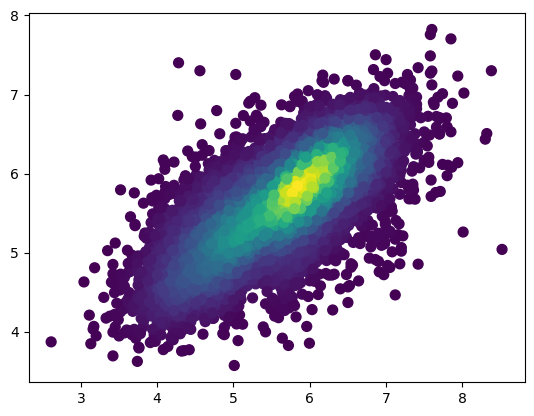

In [26]:
ph_predict = model.predict(dtest_reg)
ph_true = y_test['pH']
ph = pd.DataFrame({'predict':ph_predict, 'true':ph_true})

# Generate fake data
x = ph['true']
y = ph['predict']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=50)
plt.show()

In [27]:
# this retrieves all booster and non-booster parameters
import json
config = json.loads(model.save_config()) # your xgb booster object
stack = [config]
stack

[{'learner': {'generic_param': {'fail_on_invalid_gpu_id': '0',
    'gpu_id': '-1',
    'n_jobs': '0',
    'nthread': '0',
    'random_state': '0',
    'seed': '0',
    'seed_per_iteration': '0',
    'validate_parameters': '1'},
   'gradient_booster': {'gbtree_model_param': {'num_parallel_tree': '1',
     'num_trees': '1000',
     'size_leaf_vector': '0'},
    'gbtree_train_param': {'predictor': 'auto',
     'process_type': 'default',
     'tree_method': 'exact',
     'updater': 'grow_colmaker,prune',
     'updater_seq': 'grow_colmaker,prune'},
    'name': 'gbtree',
    'specified_updater': False,
    'updater': {'grow_colmaker': {'colmaker_train_param': {'default_direction': 'learn',
       'opt_dense_col': '1'},
      'train_param': {'alpha': '0',
       'cache_opt': '1',
       'colsample_bylevel': '1',
       'colsample_bynode': '1',
       'colsample_bytree': '1',
       'eta': '0.300000012',
       'gamma': '0',
       'grow_policy': 'depthwise',
       'interaction_constraints': 